# StarGAN-V2 Demo

This notebook is for the implementation of the paper [StarGAN v2: Diverse Image Synthesis for Multiple Domains](https://arxiv.org/abs/1912.01865) using Tensorflow.

Reference: [Official Tensorflow Implementation](https://github.com/clovaai/stargan-v2) and [Stacey's colab notebook demo](https://wandb.ai/stacey/stargan/reports/Cute-Animals-and-Post-Modern-Style-Transfer-StarGAN-v2-for-Multi-Domain-Image-Synthesis---VmlldzoxNzcwODQ).

## Setup
Link the folder and check the path.


In [29]:
 from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
import os

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = "Colab Notebooks/StarGAN-V2"
GOOGLE_DRIVE_PATH = os.path.join('drive', 'MyDrive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['utils.py', 'ops.py', 'README.md', 'LICENSE', '__pycache__', 'checkpoint', 'results', 'logs', 'samples', 'networks.py', 'StarGAN-v2_new.ipynb', 'main.py', 'StarGAN_v2.py', 'StarGAN-v2.ipynb']


In [31]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

## Prepare dataset

### Download the related datasets

In [32]:
import tensorflow as tf
import tensorflow_datasets as tfds

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.experimental.AUTOTUNE

dataset, metadata = tfds.load('cycle_gan/ukiyoe2photo', with_info=True, as_supervised=True)

train_ukiyoe, train_photo = dataset['trainA'], dataset['trainB']
test_ukiyoe, test_photo = dataset['testA'], dataset['testB']
print("Ukiyoe training dataset Length: {}".format(len(train_photo)))

Ukiyoe training dataset Length: 6287


### Preprocessing

In [33]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [34]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

def preprocess_image_test(image, label):
  image = normalize(image)
  return image

In [35]:
train_ukiyoe = train_ukiyoe.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

train_photo = train_photo.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_ukiyoe = test_ukiyoe.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_photo = test_photo.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

In [36]:
sample_ukiyoe = next(iter(train_ukiyoe))
sample_photo = next(iter(train_photo))

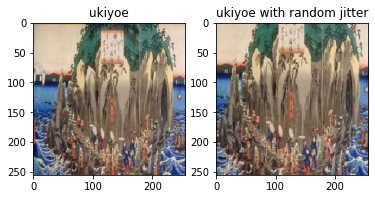

In [37]:
plt.subplot(121)
plt.title('ukiyoe')
plt.imshow(sample_ukiyoe[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('ukiyoe with random jitter')
plt.imshow(random_jitter(sample_ukiyoe[0]) * 0.5 + 0.5)

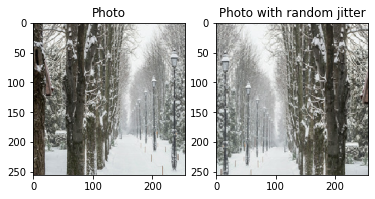

In [38]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(sample_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Photo with random jitter')
plt.imshow(random_jitter(sample_photo[0]) * 0.5 + 0.5)

### Download dataset to "data"

In [39]:
# Create data/
!mkdir data/
!mkdir data/style/
!mkdir data/style/train/
!mkdir data/style/test/
!mkdir data/style/test/ref_imgs

# Download Datasets from UCB
!wget -cO - https://people.eecs.berkeley.edu/%7Etaesung_park/CycleGAN/datasets/cezanne2photo.zip > cezanne.zip
!wget -cO - https://people.eecs.berkeley.edu/%7Etaesung_park/CycleGAN/datasets/monet2photo.zip > monet.zip
!wget -cO - https://people.eecs.berkeley.edu/%7Etaesung_park/CycleGAN/datasets/ukiyoe2photo.zip > ukiyoe.zip
!wget -cO - https://people.eecs.berkeley.edu/%7Etaesung_park/CycleGAN/datasets/vangogh2photo.zip > vangogh.zip

# Unzip files
!unzip cezanne.zip
!unzip monet.zip
!unzip ukiyoe.zip
!unzip vangogh.zip

!rm -f cezanne.zip
!mv cezanne2photo/trainA/ data/style/train/cezanne/
!mv cezanne2photo/testA/ data/style/test/ref_imgs/cezanne/
!mv cezanne2photo/trainB/ data/style/train/photo/
!mv cezanne2photo/testB/ data/style/test/src_imgs/
!rm -r cezanne2photo/

!rm -f monet.zip
!mv monet2photo/trainA/ data/style/train/monet/
!mv monet2photo/testA/ data/style/test/ref_imgs/monet/
!rm -r monet2photo/

!rm -f ukiyoe.zip
!mv ukiyoe2photo/trainA/ data/style/train/ukiyoe/
!mv ukiyoe2photo/testA/ data/style/test/ref_imgs/ukiyoe/
!rm -r ukiyoe2photo/

!rm -f vangogh.zip
!mv vangogh2photo/trainA/ data/style/train/vangogh/
!mv vangogh2photo/testA/ data/style/test/ref_imgs/vangogh/
!rm -r vangogh2photo/

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: vangogh2photo/trainB/2016-08-26 19:25:29.jpg  
  inflating: vangogh2photo/trainB/2016-02-20 16:54:25.jpg  
  inflating: vangogh2photo/trainB/2015-05-19 19:43:44.jpg  
  inflating: vangogh2photo/trainB/2015-10-26 21:18:58.jpg  
  inflating: vangogh2photo/trainB/2014-07-19 15:39:53.jpg  
  inflating: vangogh2photo/trainB/2015-06-13 21:21:54.jpg  
  inflating: vangogh2photo/trainB/2015-06-04 14:10:33.jpg  
  inflating: vangogh2photo/trainB/2014-06-18 12:46:34.jpg  
  inflating: vangogh2photo/trainB/2016-03-17 18:07:22.jpg  
  inflating: vangogh2photo/trainB/2015-01-24 17:24:29.jpg  
  inflating: vangogh2photo/trainB/2016-01-27 12:45:41.jpg  
  inflating: vangogh2photo/trainB/2016-06-14 05:57:28.jpg  
  inflating: vangogh2photo/trainB/2015-12-24 01:48:36.jpg  
  inflating: vangogh2photo/trainB/2015-10-18 05:19:51.jpg  
  inflating: vangogh2photo/trainB/2015-01-23 07:43:34.jpg  
  inflating: vangogh2photo/trainB/2016-04-29 18:08:01.jpg  
  inflating: 

## StarGAN-V2

In [ ]:
!pip install tqdm --upgrade
!pip install Pillow --upgrade

import numpy as np
import os
import cv2
import math
import random
import time
import PIL.Image
from glob import glob
from tqdm import tqdm
from tqdm.contrib import tenumerate
from copy import deepcopy

import tensorflow as tf
from tensorflow.keras import Sequential
import tensorflow_addons as tfa
from tensorflow.python.data.experimental import AUTOTUNE, prefetch_to_device


In [48]:
!ls data/style/test/ref_imgs

cezanne  monet	ukiyoe	vangogh


In [14]:
!python drive/MyDrive/'Colab Notebooks'/StarGAN-V2/main.py --dataset style/ \
          --phase train \
          --iteration 15000 --ds_iter 15000 \
          --batch_size 8 \
          --checkpoint_dir drive/MyDrive/'Colab Notebooks'/StarGAN-V2/checkpoint \
          --result_dir drive/MyDrive/'Colab Notebooks'/StarGAN-V2/results \
          --log_dir drive/MyDrive/'Colab Notebooks'/StarGAN-V2/logs \
          --sample_dir drive/MyDrive/'Colab Notebooks'/StarGAN-V2/samples

流式输出内容被截断，只能显示最后 5000 行内容。
iter: [ 10002/ 15000] time: 3.4954 d_loss: 2.66856861, g_loss: 8.58768082
iter: [ 10003/ 15000] time: 3.4945 d_loss: 2.80672812, g_loss: 9.37525940
iter: [ 10004/ 15000] time: 3.4941 d_loss: 3.16579318, g_loss: 9.37382507
iter: [ 10005/ 15000] time: 3.5007 d_loss: 3.38073921, g_loss: 10.13843250
iter: [ 10006/ 15000] time: 3.4935 d_loss: 2.35504532, g_loss: 11.75300694
iter: [ 10007/ 15000] time: 3.4928 d_loss: 2.91647577, g_loss: 8.78586197
iter: [ 10008/ 15000] time: 3.4964 d_loss: 2.59013653, g_loss: 8.96681595
iter: [ 10009/ 15000] time: 3.4918 d_loss: 2.58781695, g_loss: 10.55462837
iter: [ 10010/ 15000] time: 3.4927 d_loss: 3.16089725, g_loss: 10.82929611
iter: [ 10011/ 15000] time: 3.4995 d_loss: 2.65221524, g_loss: 8.90407372
iter: [ 10012/ 15000] time: 3.4967 d_loss: 2.76623154, g_loss: 11.07941246
iter: [ 10013/ 15000] time: 3.4913 d_loss: 2.74914932, g_loss: 9.33247375
iter: [ 10014/ 15000] time: 3.4954 d_loss: 2.49592400, g_loss: 9.57549572
iter: 

In [49]:
!python drive/MyDrive/'Colab Notebooks'/StarGAN-V2/main.py --dataset style/ \
          --phase test \
          --iteration 15000 --ds_iter 15000 \
          --batch_size 8 \
          --merge False \
          --checkpoint_dir drive/MyDrive/'Colab Notebooks'/StarGAN-V2/checkpoint \
          --result_dir drive/MyDrive/'Colab Notebooks'/StarGAN-V2/results \
          --log_dir drive/MyDrive/'Colab Notebooks'/StarGAN-V2/logs \
          --sample_dir drive/MyDrive/'Colab Notebooks'/StarGAN-V2/samples

2020-12-18 03:04:10.814531: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2020-12-18 03:04:12.621783: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2020-12-18 03:04:12.623031: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2020-12-18 03:04:12.625549: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-12-18 03:04:12.626081: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2020-12-18 03:04:12.626112: I tensorflow/stream_executor/platform/def